# Nonlocality Optimization in the Bi-local Scenario

This notebook uses the bi-local Bell inequalities described in  [https://arxiv.org/abs/1112.4502](https://arxiv.org/abs/1112.4502).

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


## Binary Inputs and Outputs

Consider a bi-local scenario with inputs and outputs $x,y,z,a,b,c\in\{0,1\}$.
The correlator is then defined as

$$
\langle A_x B_y C_z \rangle_{P_{22}} := \sum_{a,b,c}(-1)^{a+b+c}P_{22}(a,b,c|x,y,x).
$$

The following linear combinations will be useful:

$$
I_{22} := \frac{1}{4}\sum_{x,z\in\{0,1\}}\langle A_x B_0 C_z\rangle_{P_{22}}, \quad \text{and}
$$

$$
J_{22} := \frac{1}{4}\sum_{x,z\in\{0,1\}}(-1)^{x+z}\langle A_x B_1 C_z\rangle_{P_{22}}.
$$

The non-linear bi-local Bell inequality is then expressed as $\sqrt{|I_{22}|} + \sqrt{|J_{22}|} \leq 1.$

In [29]:
# The bi-local scenario requires 4 qubits ["a","b0","b1",c]
dev = qml.device("default.qubit", wires=["a","b0","b1","c"])

# optimizer
opt = qml.GradientDescentOptimizer()

@qml.qnode(dev)
def real_bilocal_measurement_circuit(a_measurement, b_measurement, c_measurement):  
    """
    Ansatz circuit where maximally entangled bipartite states are prepared and
    measurents are free to rotate about the y-axis.
    In this model, all quantum states real.
    This scenario considers binary inputs and outputs for all parties.

    Args:
        a_measurement (float) : 1 rotation angle of Alice's measurement
        b_measurement (array[float]) : 15 rotation angles of Bob's 2-qubit measurement 
        c_measurement (float) : 1 rotation angle of Charlie's measurement
    """
    # prepare entanglement between Alice and Bob
    qml.Hadamard(wires="a")
    qml.CNOT(wires=["a", "b0"])
    
    # prepare entanglement between Bob and Charlie
    qml.Hadamard(wires="c")
    qml.CNOT(wires=["c","b1"])
    
    # single qubit measurement for Alice and Charlie
    qml.RY(a_measurement, wires="a")
    qml.RY(c_measurement, wires="c")
    
    # 2-qubit measurement for Bob
    qml.RY(b_measurement[0], wires="b0")
    qml.RY(b_measurement[1], wires="b1")

    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b0") @ qml.PauliZ("b1") @ qml.PauliZ("c"))

In [16]:
def real_bilocal_measurement_settings():
    """
    Returns an array containing randomized tensors containing input values for
    `real_bilocal_measurement_circuit()`.
    """
    return [
        2*np.pi*np.random.random((2, 1)) - np.pi,
        2*np.pi*np.random.random((2, 2)) - np.pi,
        2*np.pi*np.random.random((2, 1)) - np.pi
    ]

In [57]:
def real_bilocal_measurement_cost(settings):
    """
    Applies the bilocality inequality as a cost function with respect to the `real_bilocal_measurement_circuit()`.
    """
    I22_run1 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0]
    )
    I22_run2 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][0],
        settings[2][0]
    )
    I22_run3 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1]
    )
    I22_run4 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][0],
        settings[2][1]
    ) 
    I22 = (I22_run1 + I22_run2 + I22_run3 + I22_run4)/4
    
    J22_run1 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][1],
        settings[2][0]
    )
    J22_run2 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][1],
        settings[2][0]
    )
    J22_run3 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][1],
        settings[2][1]
    )
    J22_run4 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][1],
        settings[2][1]
    )
    J22 = (J22_run1 - J22_run2 - J22_run3 + J22_run4)/4

    return -1*(np.sqrt(abs(I22)) + np.sqrt(abs(J22)))

In [58]:
# initial settings
real_settings = real_bilocal_measurement_settings()
real_scores = []

# performing gradient descent
for i in range(500):
    real_settings = opt.step(real_bilocal_measurement_cost, real_settings)
    score = -(real_bilocal_measurement_cost(real_settings))
    real_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", real_settings, "\n")

# printing final results    
print("final score : ", score,",")
print("final settings : ", real_settings)

iteration :  0 , score :  0.8268111820431274
settings :
 [array([[3.10751155],
       [0.1738026 ]]), array([[ 1.48011669, -2.3436165 ],
       [ 2.2049385 , -1.74057809]]), array([[-1.3436567],
       [ 0.7321358]])] 

iteration :  50 , score :  1.0648986697836451
settings :
 [array([[2.86540287],
       [0.20048133]]), array([[ 1.48517322, -2.4315457 ],
       [ 2.41531191, -1.75921244]]), array([[-1.29977749],
       [ 0.79482015]])] 

iteration :  100 , score :  1.185680006568105
settings :
 [array([[2.70098453],
       [0.22735597]]), array([[ 1.48587251, -2.52380626],
       [ 2.55215633, -1.76636418]]), array([[-1.24582078],
       [ 0.84027574]])] 

iteration :  150 , score :  1.2570175048648569
settings :
 [array([[2.58076108],
       [0.25821481]]), array([[ 1.48182137, -2.61022074],
       [ 2.64557207, -1.76351929]]), array([[-1.1898956 ],
       [ 0.86792015]])] 

iteration :  200 , score :  1.3029951240695794
settings :
 [array([[2.49038657],
       [0.29107182]]), array(

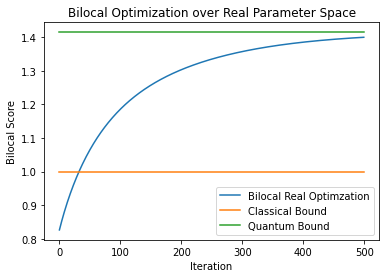

In [59]:
# Plot the score of the Bell inequality
plt.plot(range(500), real_scores , label = "Bilocal Real Optimzation")
plt.plot(range(500), [1]*500, label = "Classical Bound")
plt.plot(range(500), [2*np.sqrt(1/2)]*500, label = "Quantum Bound")
plt.title("Bilocal Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel("Bilocal Score")
plt.legend()
plt.show()

## Bob has a 1 Input and 4 Outputs

This scenario represents the case where Bob performs a complete Bell measurement on the two-qubit states.
The correlator is defined:

$$
\langle A_x B^y C_z \rangle_{P_{14}} := \sum_{a,b^0 b^1,c}(-1)^{a+b^y+c}P_{14}(a,b^0 b^1,c|x,z)
$$

The following linear combinations simplify the Bell inequality:

$$
I_{14} := \frac{1}{4}\sum_{x,z\in 0,1}\langle A_x B^0 C_z\rangle_{P_{14}}, \quad \text{and}
$$

$$
J_{14} := \frac{1}{4}\sum_{x,z \in 0,1}(-1)^{x+z}\langle A_x B^y C_z \rangle_{P_{14}}.
$$

The Bilocal Bell inequality is then expressed as $\sqrt{|I_{14}|} + \sqrt{|J_{14}|} \leq 1.$


In [18]:
settings[1][0]

tensor([ 2.79195668, -1.88513123], requires_grad=True)

In [20]:
np.sqrt(2)

1.4142135623730951

In [21]:
abs(-1)

1

In [22]:
np.abs(-2)

2

In [23]:
sum([1,2,3,4])

10

In [53]:
np.sqrt(1/2) + np.sqrt(1/2)

1.4142135623730951